In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler  # Perbaikan: MinMaxScaler diganti dengan StandardScaler sesuai konteks
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# 1. Membaca dataset
# Perbaikan: Menghapus dependensi Google Colab
# Ganti dengan lokasi file dataset di komputer lokal Anda
file_path = "../data/crop_recommendation.csv"  # Menggunakan '..' untuk naik satu tingkat ke folder Project
df = pd.read_csv(file_path)

In [2]:
# 2. Memisahkan fitur dan label
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X = df[features]
y = df['label']

In [3]:
# 3. Standarisasi Fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# 4. Menghitung Jarak Antar Baris
# Menghitung matriks jarak Euclidean
distance_matrix = cdist(X_scaled, X_scaled, metric='euclidean')

Statistik Jarak Euclidean Setelah Normalisasi:
Min: 0.1047
Max: 8.6692
Mean: 3.5260
Median: 3.4338


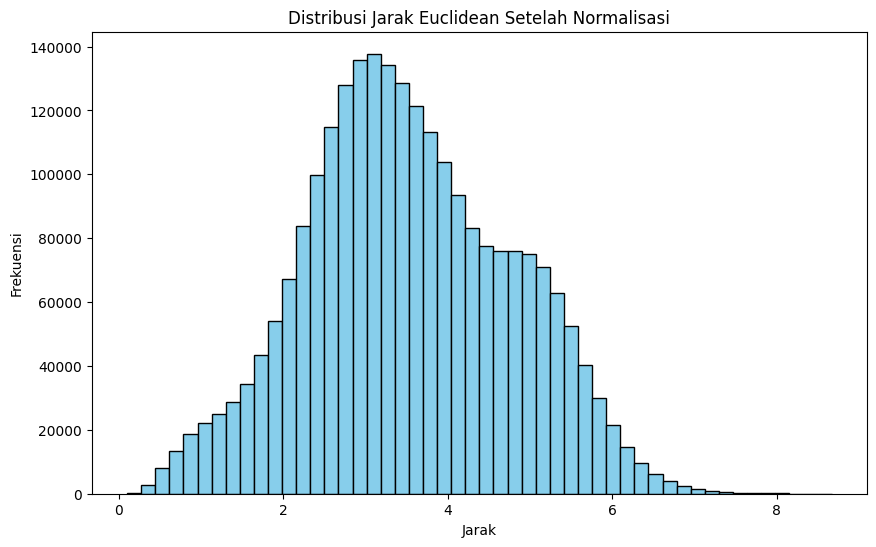

In [5]:
# Analisis Distribusi Jarak
distances = distance_matrix[np.triu_indices(len(distance_matrix), k=1)]
print("Statistik Jarak Euclidean Setelah Normalisasi:")
print(f"Min: {np.min(distances):.4f}")
print(f"Max: {np.max(distances):.4f}")
print(f"Mean: {np.mean(distances):.4f}")
print(f"Median: {np.median(distances):.4f}")

# Visualisasi distribusi jarak
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribusi Jarak Euclidean Setelah Normalisasi")
plt.xlabel("Jarak")
plt.ylabel("Frekuensi")
plt.show()

In [6]:
# 5. Identifikasi data yang mirip dengan label berbeda berdasarkan threshold
threshold = 0.4
similar_pairs = []

for i in range(len(X_scaled)):
    for j in range(i + 1, len(X_scaled)):
        if distance_matrix[i, j] <= threshold and y.iloc[i] != y.iloc[j]:
            similar_pairs.append((i, j, distance_matrix[i, j], y.iloc[i], y.iloc[j]))

print("\n=== Data Mirip dengan Label Berbeda ===")
print("\nJumlah data yang mirip:", len(similar_pairs))
for pair in similar_pairs:
    print(f"Index {pair[0]} ({pair[3]}) vs Index {pair[1]} ({pair[4]}): Distance = {pair[2]:.4f}")


=== Data Mirip dengan Label Berbeda ===

Jumlah data yang mirip: 11
Index 13 (rice) vs Index 2085 (jute): Distance = 0.3898
Index 29 (rice) vs Index 2037 (jute): Distance = 0.2843
Index 31 (rice) vs Index 2012 (jute): Distance = 0.3756
Index 45 (rice) vs Index 2065 (jute): Distance = 0.2808
Index 65 (rice) vs Index 2097 (jute): Distance = 0.3438
Index 65 (rice) vs Index 2098 (jute): Distance = 0.3281
Index 83 (rice) vs Index 2011 (jute): Distance = 0.2970
Index 95 (rice) vs Index 2088 (jute): Distance = 0.2949
Index 508 (mothbeans) vs Index 839 (lentil): Distance = 0.2341
Index 719 (blackgram) vs Index 818 (lentil): Distance = 0.2703
Index 784 (blackgram) vs Index 818 (lentil): Distance = 0.3199


In [7]:
# 6. Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_model = SVC(kernel='linear', random_state=42)

fold = 1
accuracies = []
confusion_matrices = []

for train_idx, test_idx in cv.split(X_scaled, y):
    # Membagi data menjadi training dan test
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Melatih model
    svm_model.fit(X_train, y_train)

    # Evaluasi pada data training
    y_train_pred = svm_model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_prec = precision_score(y_train, y_train_pred, average='weighted')
    train_rec = recall_score(y_train, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')

    # Evaluasi pada data test
    y_test_pred = svm_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred, average='weighted')
    test_rec = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Simpan hasil evaluasi
    accuracies.append(test_acc)
    confusion_matrices.append(confusion_matrix(y_test, y_test_pred))

    print(f"\n=== Fold {fold} ===")
    print(f"Training - Akurasi: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1-Score: {train_f1:.4f}")
    print(f"Test - Akurasi: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}, F1-Score: {test_f1:.4f}")

    fold += 1


=== Fold 1 ===
Training - Akurasi: 0.9915, Precision: 0.9916, Recall: 0.9915, F1-Score: 0.9915
Test - Akurasi: 0.9818, Precision: 0.9846, Recall: 0.9818, F1-Score: 0.9816

=== Fold 2 ===
Training - Akurasi: 0.9886, Precision: 0.9888, Recall: 0.9886, F1-Score: 0.9887
Test - Akurasi: 0.9886, Precision: 0.9896, Recall: 0.9886, F1-Score: 0.9886

=== Fold 3 ===
Training - Akurasi: 0.9898, Precision: 0.9903, Recall: 0.9898, F1-Score: 0.9897
Test - Akurasi: 0.9818, Precision: 0.9820, Recall: 0.9818, F1-Score: 0.9817

=== Fold 4 ===
Training - Akurasi: 0.9886, Precision: 0.9893, Recall: 0.9886, F1-Score: 0.9886
Test - Akurasi: 0.9841, Precision: 0.9851, Recall: 0.9841, F1-Score: 0.9842

=== Fold 5 ===
Training - Akurasi: 0.9892, Precision: 0.9895, Recall: 0.9892, F1-Score: 0.9892
Test - Akurasi: 0.9864, Precision: 0.9869, Recall: 0.9864, F1-Score: 0.9863


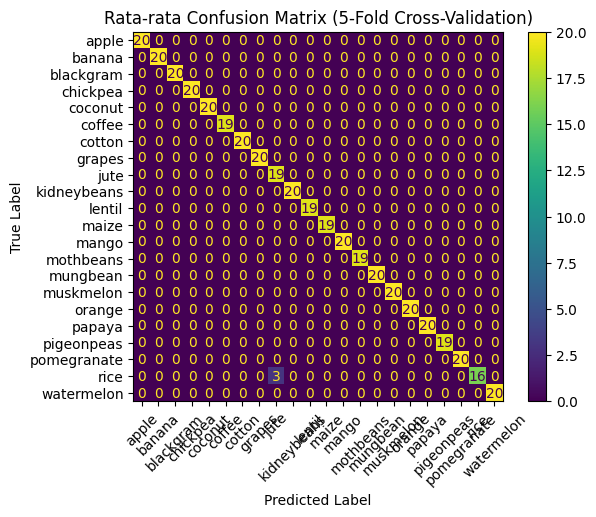

In [8]:
# 7. Menghitung Metrik Evaluasi
avg_cm = np.mean(confusion_matrices, axis=0).astype(int)
disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm, display_labels=svm_model.classes_)
disp.plot(cmap='viridis', xticks_rotation=45)
disp.ax_.set_title("Rata-rata Confusion Matrix (5-Fold Cross-Validation)")
disp.ax_.set_xlabel("Predicted Label")
disp.ax_.set_ylabel("True Label")
plt.show()

In [14]:
# Pipeline Model
from sklearn.pipeline import Pipeline
from joblib import dump

# Membuat pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Preprocessing: Standarisasi
    ('svm', SVC(kernel='linear', random_state=42))  # Model: SVM
])

# Melatih pipeline pada seluruh data
pipeline.fit(X_scaled, y)

# Menyimpan pipeline ke dalam file
model_file = "../deployment/crop_recommendation_pipeline.pkl"
dump(pipeline, model_file)

print(f"Pipeline model telah disimpan di file: {model_file}")


Pipeline model telah disimpan di file: ../deployment/crop_recommendation_pipeline.pkl
